### Set hyperparameters and load data

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [2]:
#from utils.train import train
import random

import numpy as np
import torch


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

In [4]:
set_seed(42)
use_pre_paired = True
learning_rate = 1e-5
epochs = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_size = 16
pooling = 'global_avg'
patience = 50
alpha = 1.0
target_decay = 0.996

In [5]:
# load data 
from QCCL.Data import load_graphs

basic_data, _ = load_graphs()

	Collected 1 sample from null_ops.
	Collected 4 samples from commutations.
	Collected 7 samples from equivalences.
	Collected 7 samples from combined.
Loaded 19 samples and 19 quantum circuits from subset.


### Train-Validation-Test Split

In [6]:
# from sklearn.model_selection import train_test_split
# test_mask = torch.zeros(len(basic_data), dtype=torch.bool)
# test_mask[12:14] = True
# val_mask = torch.zeros(len(basic_data), dtype=torch.bool)
# val_mask[14:17] = True

# train_data = [basic_data[i] for i in range(len(basic_data)) if not test_mask[i] and not val_mask[i]]
# val_data = [basic_data[i] for i in range(len(basic_data)) if val_mask[i]]
# test_data = [basic_data[i] for i in range(len(basic_data)) if test_mask[i]]

# # train_data, val_data = train_test_split(train_data, train_size=0.8, shuffle=True)
# print('Data split:')
# print('train:', len(train_data), '(', round((len(train_data) / len(basic_data)) * 100, 1), '%)')
# print('val:', len(val_data), '(', round((len(val_data) / len(basic_data)) * 100, 1), '%)')
# print('test:', len(test_data), '(', round((len(test_data) / len(basic_data)) * 100, 1), '%)')

# train_dataset = GraphDataset(train_data, pre_paired=use_pre_paired)
# val_dataset = GraphDataset(val_data, pre_paired=use_pre_paired)
# test_dataset = GraphDataset(test_data, pre_paired=use_pre_paired)

In [7]:
from QCCL.Data import split_dataset

train_dataset, val_dataset, test_dataset = split_dataset(basic_data, 0.7, 0.3, use_pre_paired=use_pre_paired)


Starting dataset split...
Total dataset size: 19
Composite transformations size: 7
Splitting into 14 training, 5 validation, and 0 test circuits...
Data split completed:
Training set: 14 samples, (73.68%)
Validation set: 5 samples, (26.32%)
Test set: 0 samples, (0.00%)


In [8]:
batch_size = len(train_dataset)
print('Batch size:', batch_size)

Batch size: 14


In [9]:
n_features = train_dataset[0][0].x.shape[1] if use_pre_paired else train_dataset[0].x.shape[1]
print(f'Number of features in the dataset: {n_features}')

Number of features in the dataset: 6


In [10]:
from QCCL.Models import build_model

model = build_model(n_features, embedding_size, 'byol', num_layers=5, proj_output_size=4, device=device, hidden_size=64)

c:\Users\melan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Building model with 5 GCNConv layers and projection size 4...
BYOL model built successfully.


In [11]:
# from torch.optim import Adam

# optimizer = Adam(model.online_model.parameters(), lr=learning_rate)
# history = model.train(train_dataset, val_dataset, optimizer=optimizer, epochs=epochs, batch_size=batch_size, patience=patience, verbose=False)

In [12]:
from QCCL.utils import train_byol

history = train_byol(model, train_dataset, val_dataset, 
                     tau=target_decay,
                     epochs=epochs, 
                     batch_size=batch_size, 
                     lr=learning_rate, 
                     patience=patience, 
                     ema_alpha=alpha, 
                     verbose=False, 
                     device=device, 
                     compute_grads=True)

EMA Loss:  False


Training: 100%|██████████| 1000/1000 [01:30<00:00, 11.07epoch/s, loss=0.0037, val_loss=0.0105]


In [13]:
# from QCCL.utils import train_byol

# history = train_byol(model, train_dataset, val_dataset, epochs, batch_size, learning_rate, temperature, device, patience= patience, verbose=False)

<function matplotlib.pyplot.show(close=None, block=None)>

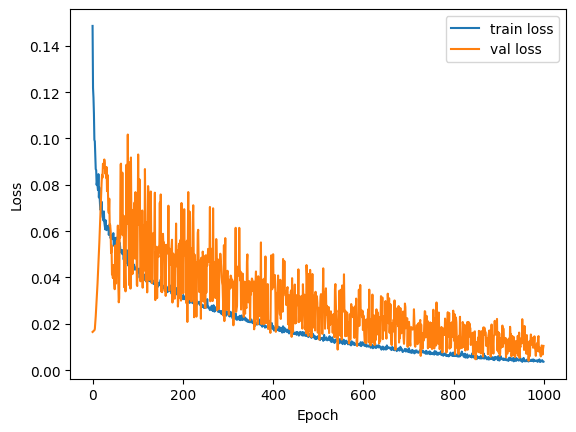

In [14]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
# show epoch with best validation loss
# best_epoch = len(history['val_loss']) - patience
# plt.axvline(best_epoch, color='black', linestyle='--', label='best epoch')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show

In [15]:
history['train_loss'][0]

0.14858859777450562

In [16]:
history['avg_grad_norm_l1_per_param'][0]

86.30637919399064

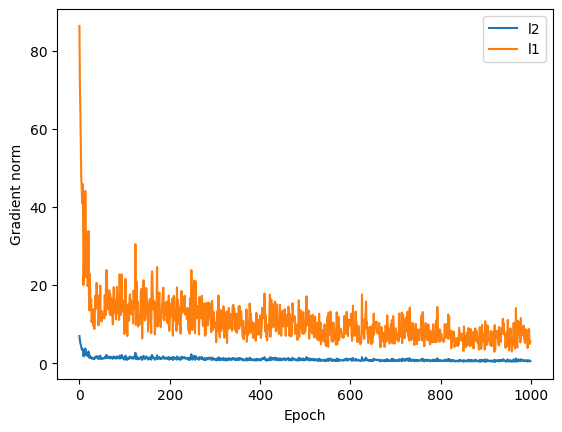

In [17]:
# plot gradients
plt.plot(history['grad_norm_l2'], label='l2')
plt.plot(history['avg_grad_norm_l1_per_param'], label='l1')
plt.xlabel('Epoch')
plt.ylabel('Gradient norm')
plt.legend()
plt.show()

### Notice that the training is much smoother wrt SimCLR

In [18]:
from QCCL.Data import from_nx_to_geometric

idx1, idx2 = np.random.choice(len(train_dataset), 2, replace=False)

pos1 = from_nx_to_geometric(train_dataset.graphs[idx1][0])
pos2 = from_nx_to_geometric(train_dataset.graphs[idx1][1])

neg1 = from_nx_to_geometric(train_dataset.graphs[idx2][0])
neg2 = from_nx_to_geometric(train_dataset.graphs[idx2][1])

In [19]:
# print embeddings
gnn = model.get_gnn()

# pos1, pos2 = val_dataset[0]
# neg1, neg2 = val_dataset[1]

# Extract embeddings
emb1 = gnn(pos1)
emb2 = gnn(pos2)

neg_emb1 = gnn(neg1)
neg_emb2 = gnn(neg2)

In [20]:
print('Positive pair:')
print('Embedding 1:', emb1)
print('Embedding 2:', emb2)

print('Negative pair:')
print('Embedding 1:', neg_emb1)
print('Embedding 2:', neg_emb2)

Positive pair:
Embedding 1: tensor([[0.0000, 0.0000, 0.0470, 0.0406, 0.0000, 0.0540, 0.0056, 0.0115, 0.0223,
         0.0000, 0.0180, 0.0044, 0.0141, 0.0000, 0.0267, 0.0000]],
       grad_fn=<MeanBackward1>)
Embedding 2: tensor([[0.0000, 0.0000, 0.0405, 0.0235, 0.0000, 0.0513, 0.0038, 0.0133, 0.0329,
         0.0000, 0.0233, 0.0007, 0.0277, 0.0051, 0.0332, 0.0000]],
       grad_fn=<MeanBackward1>)
Negative pair:
Embedding 1: tensor([[0.0000, 0.0000, 0.0228, 0.0006, 0.0001, 0.0250, 0.0000, 0.0128, 0.0381,
         0.0009, 0.0145, 0.0194, 0.0422, 0.0113, 0.0230, 0.0008]],
       grad_fn=<MeanBackward1>)
Embedding 2: tensor([[0.0000, 0.0000, 0.0170, 0.0000, 0.0012, 0.0184, 0.0000, 0.0145, 0.0327,
         0.0015, 0.0105, 0.0247, 0.0407, 0.0086, 0.0164, 0.0009]],
       grad_fn=<MeanBackward1>)


In [21]:
# check collapse by checking the distance between the embeddings
from torch.nn.functional import cosine_similarity

print('Cosine similarity between positive pair:', cosine_similarity(emb1, emb2))
print('Cosine similarity between negative pair:', cosine_similarity(neg_emb1, neg_emb2))

# check if the embeddings are different
print('Cosine similarity between positive and negative pair:', cosine_similarity(emb1, neg_emb1))

# check if the embeddings are different
print('Cosine similarity between positive and negative pair:', cosine_similarity(emb2, neg_emb2))

Cosine similarity between positive pair: tensor([0.9561], grad_fn=<SumBackward1>)
Cosine similarity between negative pair: tensor([0.9860], grad_fn=<SumBackward1>)
Cosine similarity between positive and negative pair: tensor([0.7047], grad_fn=<SumBackward1>)
Cosine similarity between positive and negative pair: tensor([0.7756], grad_fn=<SumBackward1>)


In [22]:
online_model = model.online_model
target_model = model.target_model

output_online = online_model(pos1)
output_target = target_model(pos2)

print('Output online:', output_online)
print('Output target:', output_target)

Output online: tensor([[-0.0557, -0.1065, -0.0225, -0.0566]], grad_fn=<AddmmBackward0>)
Output target: tensor([[-0.0619, -0.0588, -0.0091, -0.0755]])


In [23]:
# compute loss for positive pair
from torch.nn import MSELoss
loss = MSELoss()
loss_pos = loss(output_online, output_target)
print('Loss for positive pair:', loss_pos)

Loss for positive pair: tensor(0.0007, grad_fn=<MseLossBackward0>)
